In [2]:
from src.classes import *
import pandas as pd
import argparse
import os
import re
import pickle
import scanpy as sc
from datetime import date

sc.settings.verbosity = 3 

In [1]:
sample_file = '../../data/ST_files/TX.txt'
h5ad_folder = '../../data/st_data_pre_processed/stdata_h5ad/'
dataset = 'TX'
output = '../../results/Batch_corrections/uncorrected/'

In [3]:
samples = pd.read_csv(sample_file, header=None)[0].to_list()
sample_list = []
for sample in samples:
    sample_list.append(sc.read_h5ad(f'{h5ad_folder}{sample}_stdata.h5ad'))

In [4]:
st_ad_concat = ST_Anndata()
st_ad_concat.concat_anndata(sample_list, samples = samples)
st_ad_concat.anndata

<class 'anndata._core.anndata.AnnData'>


AnnData object with n_obs × n_vars = 8206 × 15172
    obs: 'feature', 'orig_feature', 'array_row', 'array_col', 'in_tissue', 'sample', 'slide', 'median_gene_feature', 'median_transcript_feature', 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'n_transcripts', 'MT_perc', 'ribo_perc', 'G_content', 'RNOG_content'
    var: 'ensembl_id', 'name', 'gene_id', 'species', 'value', 'Gene_no_alt', 'MT', 'ribo'
    uns: 'merged', 'sample', 'spatial'
    obsm: 'spatial'

In [5]:
st_ad_concat.anndata.X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
# remove 0 count genes
print(f'There are {np.sum(np.sum(st_ad_concat.anndata.X, axis=0) == 0)} genes which have 0 count')
st_ad_concat.anndata.var['count'] = np.sum(st_ad_concat.anndata.X, axis=0)
st_ad_concat.anndata = st_ad_concat.anndata[:, st_ad_concat.anndata.var['count'] > 0]
st_ad_concat.anndata

There are 1428 genes which have 0 count


View of AnnData object with n_obs × n_vars = 8206 × 13744
    obs: 'feature', 'orig_feature', 'array_row', 'array_col', 'in_tissue', 'sample', 'slide', 'median_gene_feature', 'median_transcript_feature', 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'n_transcripts', 'MT_perc', 'ribo_perc', 'G_content', 'RNOG_content'
    var: 'ensembl_id', 'name', 'gene_id', 'species', 'value', 'Gene_no_alt', 'MT', 'ribo', 'count'
    uns: 'merged', 'sample', 'spatial'
    obsm: 'spatial'

In [7]:
# standard scanpy normalization
sc.pp.normalize_total(st_ad_concat.anndata)
sc.pp.log1p(st_ad_concat.anndata)

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


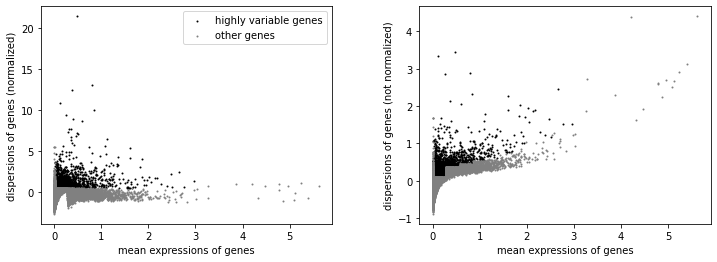

In [8]:
sc.pp.highly_variable_genes(st_ad_concat.anndata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(st_ad_concat.anndata)

# plot clusters onto the central slide
# figure(figsize=(6, 8), dpi=50)
# plt.scatter(x = st_ad_condcat.anndata.obsm['spatial'][:, 0],y= st_ad_condcat.anndata.obsm['spatial'][:, 1], 
#             c=st_ad_condcat.anndata.obs['leiden'].astype('int'), cmap='jet', s=55)
# plt.colorbar()
# plt.title('Center slide cluster assignment')
# plt.axis('off')
# plt.show()

# calculate DEG
# sc.tl.rank_genes_groups(center_slice_exp, 'leiden', method='t-test')
# sc.pl.rank_genes_groups(center_slice_exp, n_genes=25, sharey=False)

In [9]:
# save log transformed expression for later
st_ad_concat.anndata.raw = st_ad_concat.anndata.copy()
st_ad_concat.anndata = st_ad_concat.anndata[:, st_ad_concat.anndata.var.highly_variable]

# use the regress out function
# sc.pp.regress_out(st_ad_condcat.anndata, ['median_transcript_feature', 'MT_perc'])

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


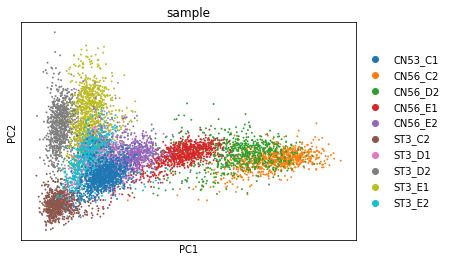

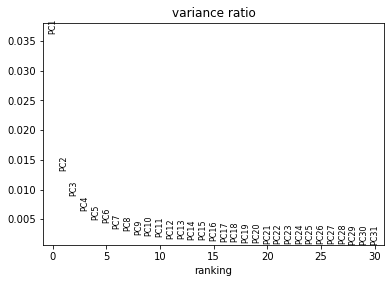

In [10]:
sc.pp.scale(st_ad_concat.anndata, max_value=10)

sc.tl.pca(st_ad_concat.anndata, svd_solver='arpack')
sc.pl.pca(st_ad_concat.anndata, color='sample')
sc.pl.pca_variance_ratio(st_ad_concat.anndata)

In [11]:
# compute neighbours and cluster
sc.pp.neighbors(st_ad_concat.anndata, n_neighbors=10, n_pcs=50)

sc.tl.umap(st_ad_condcat.anndata)
# sc.pl.umap(st_ad_concat.anndata, color=['TH', 'sample', 'PENK'], use_raw=False)

sc.tl.leiden(st_ad_concat.anndata, resolution=1)
sc.pl.umap(st_ad_concat.anndata, color=['leiden', 'sample', 'MALAT1', 'PENK'])

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()
2022-11-20 14:17:37.708862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 14:17:39.097257: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64
2022-11-20 14:17:39.097570: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] C

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)


NameError: name 'st_ad_condcat' is not defined

In [63]:
st_ad_concat.anndata.obs['cluster'] = st_ad_concat.anndata.obs['leiden']
st_ad_concat.anndata.obs['umap1'] = st_ad_concat.anndata.obsm['X_umap'][:, 0]
st_ad_concat.anndata.obs['umap2'] = st_ad_concat.anndata.obsm['X_umap'][:, 1]

In [64]:
st_ad_concat.anndata.obs

,feature,orig_feature,array_row,array_col,in_tissue,sample,slide,median_gene_feature,median_transcript_feature,x,...,pixel_y,n_transcripts,MT_perc,ribo_perc,G_content,RNOG_content,leiden,cluster,umap1,umap2
ST3_C2_X4.95_14.07,X4.95_14.07,X5_14,5.0,14.0,1,ST3_C2,ST3,1409.0,2671.0,5,...,662.7,3103.0,0.100491,0.012089,0.043829,0.956171,3,3,14.702155,12.303631
ST3_C2_X4.95_11.06,X4.95_11.06,X5_11,5.0,11.0,1,ST3_C2,ST3,1409.0,2671.0,5,...,510.1,3852.0,0.084567,0.011477,0.043614,0.956386,3,3,12.214056,13.731332
ST3_C2_X15.94_14.05,X15.94_14.05,X16_14,16.0,14.0,1,ST3_C2,ST3,1409.0,2671.0,16,...,661.4,2686.0,0.089566,0.008061,0.076694,0.923306,3,3,13.577041,12.628810
ST3_C2_X8.01_14.97,X8.01_14.97,X8_15,8.0,15.0,1,ST3_C2,ST3,1409.0,2671.0,8,...,708.4,2082.0,0.103179,0.007808,0.046110,0.953890,3,3,14.722462,12.467110
ST3_C2_X10.91_24.02,X10.91_24.02,X11_24,11.0,24.0,1,ST3_C2,ST3,1409.0,2671.0,11,...,1166.5,3651.0,0.119331,0.009649,0.036428,0.963572,3,3,14.520335,13.295352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CN53_C1_X19.95_20.05,X19.95_20.05,X20_20,20.0,20.0,1,CN53_C1,CN53,2636.0,5573.0,20,...,969.5,3023.0,0.106814,0.006998,0.085346,0.914654,0,0,9.802844,7.409799
CN53_C1_X23.22_30.02,X23.22_30.02,X23_30,23.0,30.0,1,CN53_C1,CN53,2636.0,5573.0,23,...,1473.9,7514.0,0.074495,0.010621,0.072931,0.927069,0,0,8.157907,8.289486
CN53_C1_X19.85_13.09,X19.85_13.09,X20_13,20.0,13.0,1,CN53_C1,CN53,2636.0,5573.0,20,...,617.1,5266.0,0.092042,0.010275,0.117736,0.882264,0,0,8.843628,6.790816
CN53_C1_X24.1_26.01,X24.1_26.01,X24_26,24.0,26.0,1,CN53_C1,CN53,2636.0,5573.0,24,...,1270.8,4717.0,0.084323,0.009976,0.080984,0.919016,0,0,9.117418,7.775735


In [65]:
os.makedirs(f'{output}{dataset}', exist_ok=True)
st_ad_concat.anndata.obs.to_csv(f'{output}{dataset}/{dataset}_uncorrected_clusters_combined.tsv', sep='\t')